In [1]:
# Install necessary libraries
!pip install tensorflow tensorflow-federated onnxruntime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of tensorflow-federated to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 58.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce 

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)


ERROR:jax._src.xla_bridge:Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/xla_bridge.py", line 438, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/usr/local/lib/python3.10/dist-packages/jax_plugins/xla_cuda12/__init__.py", line 85, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'


170498071/170498071 [==============================] - 14s 0us/step
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In [30]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input

# Load pre-trained MobileNet model
input_shape = (32, 32, 3)
base_model = MobileNet(input_shape=input_shape, include_top=False, weights=None)

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and store the training history
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5
782/782 [==============================] - 401s 504ms/step - loss: 1.8744 - accuracy: 0.2975 - val_loss: 1.8105 - val_accuracy: 0.3392
Epoch 2/5
782/782 [==============================] - 390s 498ms/step - loss: 1.5255 - accuracy: 0.4382 - val_loss: 1.7814 - val_accuracy: 0.4288
Epoch 3/5
782/782 [==============================] - 395s 505ms/step - loss: 1.3631 - accuracy: 0.5079 - val_loss: 1.4179 - val_accuracy: 0.5048
Epoch 4/5
782/782 [==============================] - 394s 504ms/step - loss: 1.2343 - accuracy: 0.5600 - val_loss: 1.3542 - val_accuracy: 0.5378
Epoch 5/5
782/782 [==============================] - 393s 502ms/step - loss: 1.1327 - accuracy: 0.6007 - val_loss: 1.2458 - val_accuracy: 0.5718


In [3]:
# Convert the trained model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open("mobilenet_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model converted to TensorFlow Lite format and saved as mobilenet_model.tflite")


Model converted to TensorFlow Lite format and saved as mobilenet_model.tflite


In [4]:
import numpy as np
import time

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="mobilenet_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Run inference on a test image
test_image = x_test[0:1].astype(np.float32)  # Use the first test image
start_time = time.time()

interpreter.set_tensor(input_details[0]['index'], test_image)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

end_time = time.time()
predicted_label = np.argmax(output_data)

print(f"Predicted Label: {predicted_label}, Inference Time: {end_time - start_time:.4f} seconds")


Predicted Label: 3, Inference Time: 0.0015 seconds


In [6]:
# Check the shape of one image in the client dataset
for client_dataset in client_datasets:
    for image, label in client_dataset.take(1):  # Take one example from the dataset
        print("Image shape:", image.shape)  # Should be [32, 32, 3]
        print("Label shape:", label.shape)  # Should match the label dimensions


Image shape: (20, 32, 32, 3)
Label shape: (20, 10)
Image shape: (20, 32, 32, 3)
Label shape: (20, 10)
Image shape: (20, 32, 32, 3)
Label shape: (20, 10)
Image shape: (20, 32, 32, 3)
Label shape: (20, 10)
Image shape: (20, 32, 32, 3)
Label shape: (20, 10)


In [10]:
import tensorflow as tf
print(tf.__version__)

2.14.1


In [11]:
!pip install tensorflow-federated==0.42.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tensorflow-federated to determine which version is compatible with other requirements. This could take a while.
ERROR: Ignored the following yanked versions: 0.4.32
ERROR: Ignored the following versions that require a different python version: 0.34.0 Requires-Python ~=3.9.0; 0.36.0 Requires-Python ~=3.9.0
ERROR: Could not find a version that satisfies the requirement jaxlib==0.3.14 (from tensorflow-federated) (from versions: 0.4.6, 0.4.7, 0.4.9, 0.4.10, 0.4.11, 0.4.12, 0.4.13, 0.4.14, 0.4.16, 0.4.17, 0.4.18, 0.4.19, 0.4.20, 0.4.21, 0.4.22, 0.4.23, 0.4.24, 0.4.25, 0.4.26, 0.4.27, 0.4.28, 0.4.29, 0.4.30, 0.4.31, 0.4.33, 0.4.34, 0.4.35, 0.4.36)
ERROR: No matching distribution found for jaxlib==0.3.14


In [21]:
# Install necessary libraries
!pip install tensorflow==2.14.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 4.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.14.1
    Uninstalling tensorflow-2.14.1:
      Successfully uninstalled tensorflow-2.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.14.0 which is incompatible.


In [22]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


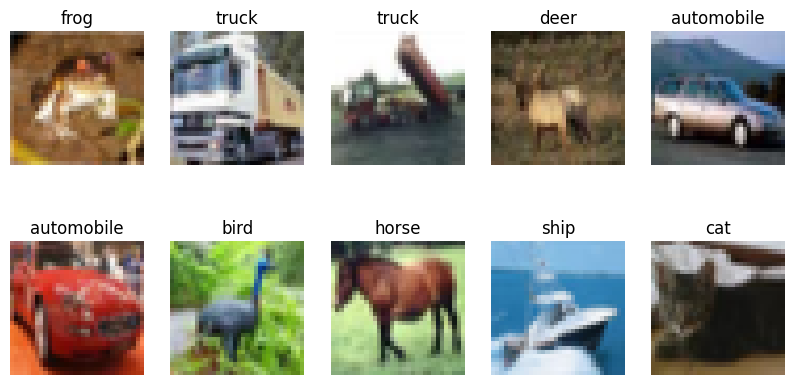

In [23]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize images to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Display sample images
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(class_names[np.argmax(y_train[i])])
    plt.axis('off')
plt.show()


In [24]:
# Convert the trained model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
tflite_model_path = 'mobilenet_cifar10.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted to TensorFlow Lite.")


Model successfully converted to TensorFlow Lite.


In [25]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function for making predictions
def predict_tflite(image):
    # Preprocess the image (resize if needed)
    image = np.expand_dims(image, axis=0).astype('float32')

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], image)

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    output = interpreter.get_tensor(output_details[0]['index'])
    return output

# Test inference on a single image
test_image = x_test[0]
test_label = y_test[0]

# Predict using TFLite model
prediction = predict_tflite(test_image)

# Display the result
predicted_class = np.argmax(prediction)
true_class = np.argmax(test_label)

print(f"Predicted Class: {class_names[predicted_class]}")
print(f"True Class: {class_names[true_class]}")


Predicted Class: cat
True Class: cat


In [26]:
import time

# Measure inference time for one image
start_time = time.time()
_ = predict_tflite(test_image)
end_time = time.time()

print(f"Inference Time: {end_time - start_time:.5f} seconds")


Inference Time: 0.00573 seconds


In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
import numpy as np

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

313/313 [==============================] - 8s 25ms/step - loss: 1.2458 - accuracy: 0.5718
Test Accuracy: 57.18%
Test Loss: 1.2458


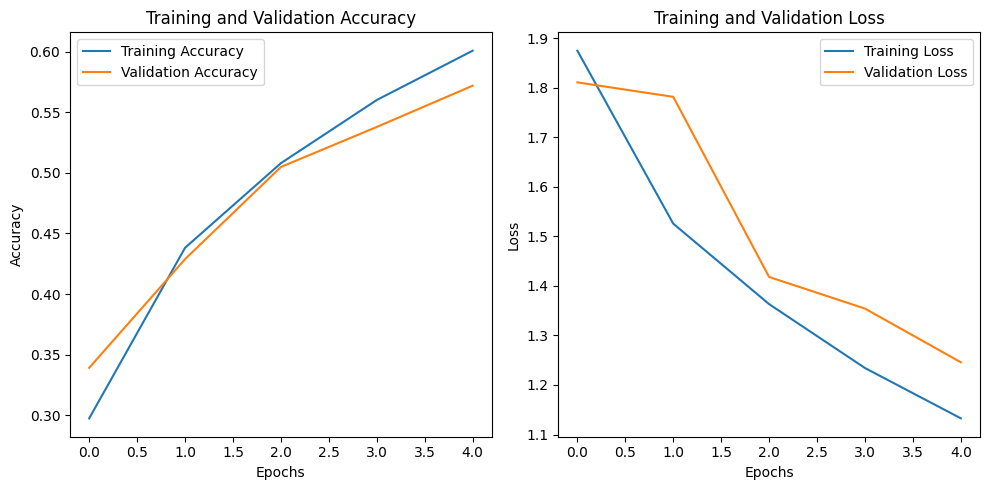

In [32]:
# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


313/313 [==============================] - 17s 52ms/step


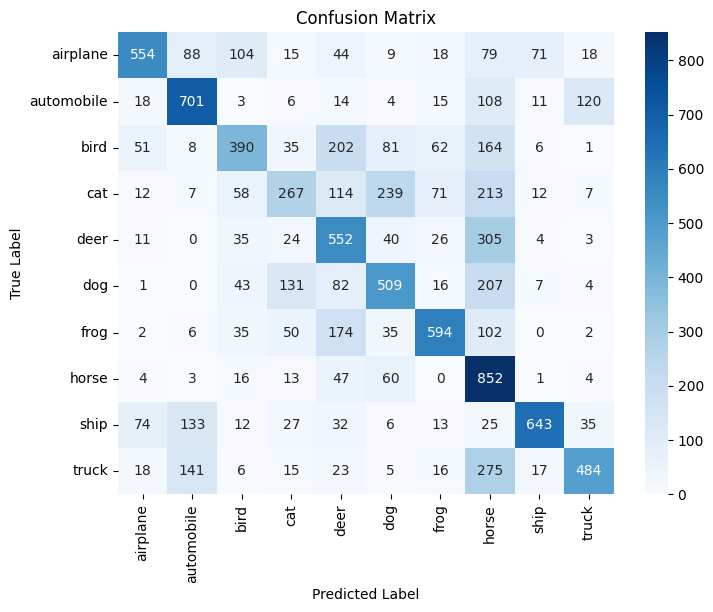

In [29]:
# Make predictions on the test set
y_pred = model.predict(x_test)

# Get the predicted class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [33]:
# Convert the trained model to TensorFlow Lite format
import tensorflow as tf

# Save the model in the TensorFlow SavedModel format
model.save("mobilenet_model")

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model("mobilenet_model")
tflite_model = converter.convert()

# Save the converted model to a file
with open("mobilenet_model.tflite", "wb") as f:
    f.write(tflite_model)


In [34]:
# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="mobilenet_model.tflite")

# Allocate tensors
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Simulate an image input (for example, the first image in the test set)
input_data = np.expand_dims(x_test[0], axis=0).astype(np.float32)  # Resize to batch shape (1, 32, 32, 3)

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Print the result
print("Predicted class probabilities:", output_data)
print("Predicted class:", np.argmax(output_data))


Predicted class probabilities: [[0.00272512 0.00170176 0.05022357 0.4991935  0.00719627 0.39735886
  0.01547289 0.01776228 0.00394438 0.00442136]]
Predicted class: 3


In [38]:
import matplotlib.pyplot as plt

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

# Print accuracy
print("Test Accuracy:", accuracy)

# Evaluate the model on the test set using TensorFlow Lite
tflite_accuracy = 0
for i in range(len(x_test)):
    input_data = np.expand_dims(x_test[i], axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    prediction = np.argmax(output_data)

    if prediction == np.argmax(y_test[i]):
        tflite_accuracy += 1

# Calculate the accuracy on the test set using TensorFlow Lite
tflite_accuracy /= len(x_test)
print("TensorFlow Lite Accuracy:", tflite_accuracy)


Test Accuracy: 0.5717999935150146
TensorFlow Lite Accuracy: 0.5718
